# ДЗ по "Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn"
##  Курсовой проект.
Задание для курсового проекта:

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на ноутбук в github или public kaggle notebook.
2. Необходимо получить R2 > 0.6.

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.
____________
Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. По возможности добавлять графики, описывающие данные (около 3-5)
4. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
5. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
6. Весь проект должен быть в одном скрипте (файл ipynb).
7. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна.
8. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров.).

### Содержание:
- [Установка необходимых пакетов, если они не установлены](#inst)
- [Импорт библиотек](#libr)
- [Загрузка датасета](#load_data)
  - [Описание данных](#description)
- [Разведочный анализ даных (EDA)](#eda)
  - [Посмотрим типы данных](#dtypes)
  - [Посмотрим пропуски данных](#pass)
  - [Посмотри статистику по датафрейму](#statistics)
  - [Визуализируем данные](#visual)
    - [Выделим численные признаки от остальных](#num_and_char)
    - [Создадим словарь признаков и их русский перевод](#translate)
    - [Визуализируем распределение числовых признаков](#num_visual)
    - [Визуализируем распределение строковых признаков](#char_visual)
- [Предобработка признаков](#predobrabotka)
  - [Посмотрим какие признаки имеют выбросы](#vibros)
  - [Признак 'HouseYear'](#house_year)
  - [Признак 'Rooms'](#rooms)
  - [Признак 'KitchenSquare'](#kitchen_square)
  - [Признаки 'Square' и 'LifeSquare'](#square_life_square)
  - [Признаки 'HouseFloor' и 'Floor'](#floor_house_floor)
  - [Признак 'Healthcare_1'](#healthcare_1)
  - [Изменим тип признаков](#type_f)
  - [Ещё раз посмотрим скорректированные данные](#cor_data)
- [Создание класса подготовки данных](#create_class)
- [Построение новых признаков](#new_feature)
  - [DistrictSize, IsDistrictLarge (размеры районов)](#district_size)
  - [MedPriceDistrict (медиана цены квартиры в зависимости от района и количества комнат)](#med_price_district)
  - [MedPriceByFloorYear (средняя цена квартиры в зависимости от этажа и года постройки дома)](#med_price_by_floor_year)
- [Создание класса новых признаков](#create_class_2)
- [Создание модели](#create_model)
  - [Проверим модель без генерации новых фич](#model_1)
  - [Проверим модель с генерацией новых фич](#model_2)
- [Прогнозирование на тестовом датасете](#prognoz)
- [Вывод](#vivod)

### Установка пакетов если они не установлены <a class='anchor' id='inst'>

In [116]:
# Для кождого проекта я использую новое окружение, 
# думаю это помогает избежать ошибок связанных с версиями пакетов
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install numpy
# !pip install scikit-learn

### Импортируем библиотеки <a class='anchor' id='libr'>

In [117]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
# Следующая магическая команда Jupyter Notebook нужна для того, чтобы графики
# отображались прямо в ноутбуке, а не в отдельном окне
%matplotlib inline

# Настройка более четкого отображения графиков
%config InlineBackend.figure_format = 'svg'

# Модуль для зазбиения выборки на тренировочнию и тестовую
from sklearn.model_selection import train_test_split

# Уберем warnings
import warnings
warnings.filterwarnings('ignore')

# Настройка формата вывода чисел float
pd.set_option('display.float_format', '{:.2f}'.format)

# Вычисление Z-score
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from scipy.stats.mstats import winsorize

# Дата и время
from datetime import datetime

# Случайные числа
import random as rnd
# Алгоритм машинного обучения 'Метод случайного леса'
from sklearn.ensemble import RandomForestRegressor

# Кросс-валидация 
from sklearn.model_selection import cross_validate

# Разбиение
from sklearn.model_selection import KFold

# Метрика r2
from sklearn.metrics import r2_score

### Загружаем данные <a class='anchor' id='load_data'>

Описание данных <a class='anchor' id='description'>
- **Id** - идентификационный номер квартиры;
- **DistrictId** - идентификационный номер района;
- **Rooms** - количество комнат;
- **Square** - площадь;
- **LifeSquare** - жилая площадь;
- **KitchenSquare** - площадь кухни;
- **Floor** - этаж;
- **HouseFloor** - количество этажей в доме;
- **HouseYear** - год постройки дома;
- **Ecology_1**, **Ecology_2**, **Ecology_3** - экологические показатели месности;
- **Social_1**, **Social_2**, **Social_3** - социальные показатели месности;
- **Healtcare_1**, **Heltcare_2** - показатели месности, связанные с охраной здоровья;
- **Shops_1**, **Shops_2** - показатели связанные с наличием магазинов, торговых центров;
- **Price** - цена квартиры.

In [118]:
# Расположение данных
TEST_DATA = '../test.csv'
TRAIN_DATA = '../train.csv'

In [119]:
# Читаем csv файл тренировочных данных
train_data = pd.read_csv(TRAIN_DATA, engine='python', on_bad_lines='skip')
train_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.00,47.98,29.44,6.00,7,9.00,1969,0.09,B,B,33,7976,5,NaN,0,11,B,184966.93
1,15053,41,3.00,65.68,40.05,8.00,7,9.00,1978,0.00,B,B,46,10309,1,240.00,1,16,B,300009.45
2,4765,53,2.00,44.95,29.20,0.00,8,12.00,1968,0.05,B,B,34,7759,0,229.00,1,3,B,220925.91
3,5809,58,2.00,53.35,52.73,9.00,8,17.00,1977,0.44,B,B,23,5735,3,1084.00,0,5,B,175616.23
4,10783,99,1.00,39.65,23.78,7.00,11,12.00,1976,0.01,B,B,35,5776,1,2078.00,2,4,B,150226.53


In [120]:
# Посмотрим размерность тренировочных данных
train_data.shape

(10000, 20)

In [121]:
# Читаем csv файл тестовых данных
test_data = pd.read_csv(TEST_DATA, engine='python', on_bad_lines='skip')
test_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.00,49.88,33.43,6.00,6,14.00,1972,0.31,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.00,69.26,NaN,1.00,6,1.00,1977,0.08,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.00,13.60,15.95,12.00,2,5.00,1909,0.00,B,B,30,7538,87,4702.00,5,5,B
3,15664,47,2.00,73.05,51.94,9.00,22,22.00,2007,0.10,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.00,47.53,43.39,1.00,17,17.00,2017,0.07,B,B,2,629,1,NaN,0,0,A


In [122]:
# Посмотрим размерность тестовых данных
test_data.shape

(5000, 19)

### Разведочный анализ даных (EDA) <a class='anchor' id='eda'>

#### Посмотрим типы данных <a class='anchor' id='dtypes'>

In [123]:
train_data.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

#### Посмотрим пропуски данных <a class='anchor' id='pass'>

In [124]:
# Настроим pd, чтобы выводились все строки 
pd.set_option('display.max_rows', None)
# Проверка того, в каких столбцах отсутствуют значения
print(train_data.isnull().sum(axis=0))
# Сбросим настройки вывода строк
pd.reset_option('display.max_rows')

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64


#### Посмотри статистику по датафрейму <a class='anchor' id='statistics'>

In [125]:
train_data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00,10000.00,10000.00,10000.00,7887.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,5202.00,10000.00,10000.00,10000.00
mean,8383.41,50.40,1.89,56.32,37.20,6.27,8.53,12.61,3990.17,0.12,24.69,5352.16,8.04,1142.90,1.32,4.23,214138.86
std,4859.02,43.59,0.84,21.06,86.24,28.56,5.24,6.78,200500.26,0.12,17.53,4006.80,23.83,1021.52,1.49,4.81,92872.29
min,0.00,0.00,0.00,1.14,0.37,0.00,1.00,0.00,1910.00,0.00,0.00,168.00,0.00,0.00,0.00,0.00,59174.78
25%,4169.50,20.00,1.00,41.77,22.77,1.00,4.00,9.00,1974.00,0.02,6.00,1564.00,0.00,350.00,0.00,1.00,153872.63
50%,8394.50,36.00,2.00,52.51,32.78,6.00,7.00,13.00,1977.00,0.08,25.00,5285.00,2.00,900.00,1.00,3.00,192269.64
75%,12592.50,75.00,2.00,65.90,45.13,9.00,12.00,17.00,2001.00,0.20,36.00,7227.00,5.00,1548.00,2.00,6.00,249135.46
max,16798.00,209.00,19.00,641.07,7480.59,2014.00,42.00,117.00,20052011.00,0.52,74.00,19083.00,141.00,4849.00,6.00,23.00,633233.47


### Визуализируем данные <a class='anchor' id='visual'>

#### Выделим численные признаки от остальных <a class='anchor' id='num_and_char'>

In [126]:
def numeric_and_string_attributes(df):
    '''
    Функция разделяет числовые и строковые признаки.

    :param df: исследуемый датафрейм,
    :return: num_cols - список числовых признаков, str_cols - список строковых признаков.
    '''
    # Числовые признаки
    num_cols = []
    # Строковые признаки
    str_cols = []
    
    cols_and_type = df.dtypes.to_dict()
    
    for col in cols_and_type:
        if cols_and_type[col] in ('int64', 'float64'):
            num_cols.append(col)
        else: 
            str_cols.append(col)

    return num_cols, str_cols

In [127]:
# Разделим числовые и строковые признаки
num_cols, str_cols = numeric_and_string_attributes(train_data)
# Выведем числовые признаки
print(num_cols)

['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Price']


In [128]:
# Выведем строковые признаки
print(str_cols)

['Ecology_2', 'Ecology_3', 'Shops_2']


#### Создадим словарь признаков и их русский перевод <a class='anchor' id='translate'>

In [129]:
# Словарь признаков и их русский перевод
translate_col = {
    'Id': 'идентификационный номер квартиры',
    'DistrictId': 'идентификационный номер района',
    'Rooms': 'количество комнат',
    'Square': 'площадь',
    'LifeSquare': 'жилая площадь',
    'KitchenSquare': 'площадь кухни',
    'Floor': 'этаж',
    'HouseFloor': 'количество этажей в доме',
    'HouseYear': 'год постройки дома',
    'Ecology_1': 'экологические показатели месности 1',
    'Ecology_2': 'экологические показатели месности 2',
    'Ecology_3': 'экологические показатели месности 3',
    'Social_1': 'социальные показатели месности 1',
    'Social_2': 'социальные показатели месности 2',
    'Social_3': 'социальные показатели месности 3',
    'Healthcare_1': 'показатели месности,\n связанные с охраной здоровья 1',
    'Helthcare_2': 'показатели месности,\n связанные с охраной здоровья 2',
    'Shops_1': 'показатели связанные с наличием\n магазинов, торговых центров 1',
    'Shops_2': 'показатели связанные с наличием\n магазинов, торговых центров 2',
    'Price': 'цена квартиры'
}

#### Визуализируем распределение числовых признаков <a class='anchor' id='num_visual'>

In [130]:
def visualization_numerical_characteristics(X=train_data, translate_col=translate_col, dop_text=''):
    '''
    Визуализация цифровых признаков (так сделал, чтобы код в одном месте находился).

    :param X: датасет, который будем визуализировать,
    :param translate_col: словарь перевода признаков на русский язык,
    :param dop_text: дополнительный текст к заголовку добавляется.
    '''
    plt.figure(figsize=[11, 13])

    # Общий заголовок для всех графиков
    plt.suptitle('Распределение числовых признаков '  + dop_text, 
                  y=1.005, 
                  fontsize=19, 
                  fontweight='bold')

    for i, col in enumerate(num_cols):
        plt.subplot(6, 3, i+1)
        # Заголовок для графика
        plt.title(f'\n{col} \n({translate_col[col]})', fontsize=10)
        # Задаём размер шривта и угол поворота текста для осей X и Y
        plt.xticks(fontsize=8, rotation=0)
        plt.yticks(fontsize=8, rotation=0)
        # Делаем размер шрифта по Y=5, не уберая название оси
        plt.ylabel('', fontsize=5)
        # Отрисовываем гистограмму
        plt.hist(X[col])

    # Автоматически уместить все элементы на полотне    
    plt.tight_layout()

    # Вывести графики на экран
    plt.show()

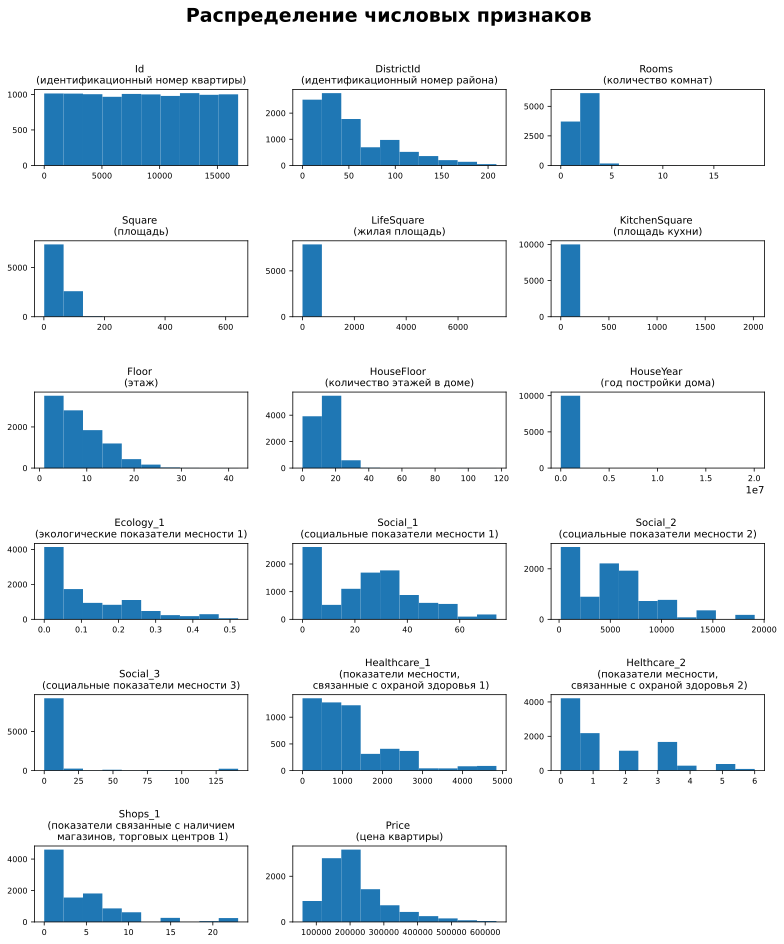

In [131]:
visualization_numerical_characteristics()

#### Визуализируем распределение строковых признаков <a class='anchor' id='char_visual'>

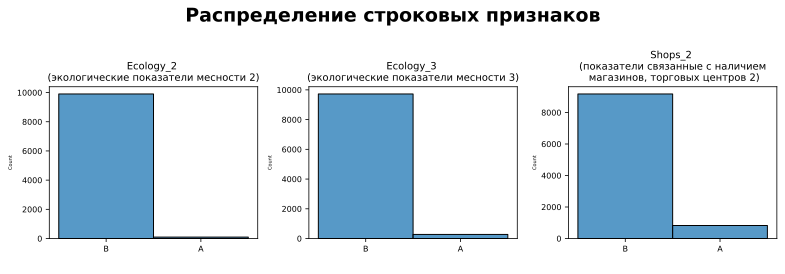

In [132]:
# Задаём размеры полотна [ширина, длина]
plt.figure(figsize=[11, 6])

# Общий заголовок для всех графиков
plt.suptitle('Распределение строковых признаков', 
              y=1.005, 
              fontsize=19, 
              fontweight='bold')
index_plt = 1
# Добавляем графики на полотно (3 шт. в одном ряду)
for col in str_cols:
    plt.subplot(2, 3, index_plt)
    # Заголовок для графика
    plt.title(f'{col} \n({translate_col[col]})', fontsize=10)
    # Задаём размер шривта и угол поворота текста для осей X и Y
    plt.xticks(fontsize=8, rotation=0)
    plt.yticks(fontsize=8, rotation=0)
    # Убираем подпись оси X
    plt.xlabel(' ')
    # Делаем размер шрифта по Y=5, не уберая название оси
    plt.ylabel('', fontsize=5)
    # Отрисовываем гистограмму
    sns.histplot(train_data[col])
    index_plt += 1

# Автоматически уместить все элементы на полотне    
plt.tight_layout()

# Вывести графики на экран
plt.show()

### Предобработка признаков <a class='anchor' id='predobrabotka'>

#### Посмотрим какие признаки имеют выбросы <a class='anchor' id='vibros'>

In [133]:
def emission_test(ds, col_test, threshold_val=3):
    '''
    Функция проводит тестирование столбцов на выбросы методом Z-score.
    
    :param ds: исследуемый датасет,
    :param col_test: список колонок,
    :param threshold_val: пороговое значение Z-score,
    :return: текстовый отчет и список выбросов.
    '''
    result = ''
    NUM = 2  # количество цифр после запятой
    outliers_list = [] # лист выбросов
    for col in col_test:
        # Вычисление Z-score
        z = np.abs(stats.zscore(ds[col]))
        # Установка порогового значения Z-score
        threshold = 3
        # Выявление выбросов на основе Z-score
        outliers = ds[col][z > threshold]
        
        if len(outliers) > 0:
            outliers_list.append(outliers)
            
            result += f'В столбце {col} ({translate_col[col]}),\n{len(outliers)} выбросов. Mean: {round(ds[col].mean(), NUM)}, ' \
            f'Min: {round(ds[col].min(), NUM)}, Max: {round(ds[col].max(), NUM)}, ' \
            f'Moda: {round(ds[col].mode()[0], NUM)}, Median: {round(ds[col].median(), NUM)} \n\n'
    
    return f'Выбросов нет. ' if result == '' else result, outliers_list

In [134]:
def viev_outliers(outliers_list, col_name):
    '''
    Функция выводит строки датафрейма, в которых есть выбросы.
    
    :param outliers_list: список выбросов,
    :param col_name: название признака (фичи),
    :return: индексы выбросов.
    '''
    for item in outliers:
        if item.name == col_name:
            return item.index 

In [135]:
# Выведем признаки которые имеют выбросы
text_outliers, outliers = emission_test(ds=train_data, col_test=num_cols)

In [136]:
# Выведем текстовый отчёт по выбросам
print(text_outliers)

В столбце DistrictId (идентификационный номер района),
88 выбросов. Mean: 50.4, Min: 0, Max: 209, Moda: 27, Median: 36.0 

В столбце Rooms (количество комнат),
22 выбросов. Mean: 1.89, Min: 0.0, Max: 19.0, Moda: 2.0, Median: 2.0 

В столбце Square (площадь),
93 выбросов. Mean: 56.32, Min: 1.14, Max: 641.07, Moda: 1.14, Median: 52.51 

В столбце KitchenSquare (площадь кухни),
6 выбросов. Mean: 6.27, Min: 0.0, Max: 2014.0, Moda: 1.0, Median: 6.0 

В столбце Floor (этаж),
66 выбросов. Mean: 8.53, Min: 1, Max: 42, Moda: 4, Median: 7.0 

В столбце HouseFloor (количество этажей в доме),
23 выбросов. Mean: 12.61, Min: 0.0, Max: 117.0, Moda: 17.0, Median: 13.0 

В столбце HouseYear (год постройки дома),
1 выбросов. Mean: 3990.17, Min: 1910, Max: 20052011, Moda: 1977, Median: 1977.0 

В столбце Ecology_1 (экологические показатели месности 1),
61 выбросов. Mean: 0.12, Min: 0.0, Max: 0.52, Moda: 0.01, Median: 0.08 

В столбце Social_2 (социальные показатели месности 2),
176 выбросов. Mean: 5352.1

#### Признак 'HouseYear' <a class='anchor' id='house_year'>

In [137]:
# Посмотрим даты, которые больше текущей даты 
train_data[train_data['HouseYear'] > datetime.now().year]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1.00,37.27,20.24,9.00,9,12.00,20052011,0.14,B,B,30,6141,10,262.00,3,6,B,254084.53
4189,11607,147,2.00,44.79,28.36,5.00,4,9.00,4968,0.32,B,B,25,4756,16,2857.00,5,8,B,243028.60


**Изменения:**

In [138]:
# Признак 'HouseYear'
# Заменим все года постройки, которые больше текущего года на моду
train_data.loc[train_data['HouseYear'] > datetime.now().year, ['HouseYear']] = train_data['HouseYear'].mode()[0]

In [139]:
# Посмотрим статиску
train_data['HouseYear'].describe()

count   10000.00
mean     1984.86
std        18.41
min      1910.00
25%      1974.00
50%      1977.00
75%      2001.00
max      2020.00
Name: HouseYear, dtype: float64

In [140]:
# Посмотрим выбросы
print(emission_test(ds=train_data, col_test=['HouseYear'])[0])

В столбце HouseYear (год постройки дома),
19 выбросов. Mean: 1984.86, Min: 1910, Max: 2020, Moda: 1977, Median: 1977.0 




**Вывод:** Убрал слишком большие даты, заменил их на моду. 

#### Признак 'Rooms' <a class='anchor' id='rooms'>

In [141]:
# Посмотрим выбросы и цену
train_data.loc[viev_outliers(outliers, 'Rooms')].sort_values(by='Rooms')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4762,4070,21,5.00,114.31,88.49,9.00,6,5.00,1960,0.03,B,B,25,5487,3,NaN,0,4,B,499830.94
8925,4214,105,5.00,85.31,56.69,5.00,4,12.00,1967,0.04,B,B,25,3478,11,2729.00,3,1,B,461678.74
8726,238,88,5.00,90.76,70.99,5.00,1,9.00,1972,0.13,B,B,43,8429,3,NaN,3,9,B,289683.94
8659,14143,13,5.00,119.01,69.03,11.00,13,17.00,2001,0.09,B,B,74,19083,2,NaN,5,15,B,434774.36
8511,4249,23,5.00,198.93,123.14,10.00,1,2.00,2011,0.01,B,B,2,475,0,NaN,0,0,B,345665.21
6988,8685,62,5.00,124.93,81.12,30.00,5,3.00,2017,0.07,B,B,2,629,1,NaN,0,0,A,271919.87
6623,3294,167,5.00,111.05,81.94,9.00,6,6.00,1940,0.05,B,B,21,4231,14,1020.00,0,3,B,513239.50
5466,3454,8,5.00,112.14,79.80,10.00,4,17.00,1999,0.44,B,B,23,5735,3,1084.00,0,5,B,471833.79
5361,2879,78,5.00,118.87,69.02,10.00,15,16.00,1998,0.09,B,B,21,4346,2,165.00,1,2,B,496026.67
9432,338,46,5.00,147.71,NaN,0.00,6,0.00,1977,0.15,B,B,16,3433,4,2643.00,4,5,B,352168.96


In [142]:
# Посмотрим количесиво квартир с различными комнатами
train_data['Rooms'].value_counts()

2.00     3880
1.00     3705
3.00     2235
4.00      150
5.00       18
0.00        8
10.00       2
19.00       1
6.00        1
Name: Rooms, dtype: int64

In [143]:
# Посмотрим квартиры с 0 комнат и ценой
train_data.query('(Rooms == 0)')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1397,12638,27,0.00,138.43,136.22,0.00,4,3.00,2016,0.08,B,B,11,3097,0,NaN,0,0,B,268394.74
1981,7917,27,0.00,212.93,211.23,0.00,2,3.00,2008,0.21,B,B,9,1892,0,NaN,0,1,B,302211.26
2269,7317,27,0.00,41.79,NaN,0.00,13,0.00,1977,0.21,B,B,9,1892,0,NaN,0,1,B,98129.98
3911,770,28,0.00,49.48,NaN,0.00,16,0.00,2015,0.12,B,B,30,6207,1,1183.00,1,0,B,217009.34
4366,456,6,0.00,81.49,NaN,0.00,4,0.00,1977,0.24,B,B,5,1564,0,540.00,0,0,B,212864.80
4853,3224,27,0.00,2.38,0.87,0.00,1,0.00,1977,0.02,B,B,2,469,0,NaN,0,0,B,126596.94
6149,3159,88,0.00,38.70,19.35,9.00,9,16.00,1982,0.13,B,B,43,8429,3,NaN,3,9,B,158998.11
8834,9443,27,0.00,87.76,85.13,0.00,5,15.00,1977,0.21,B,B,9,1892,0,NaN,0,1,B,219281.92


**Измения:**

In [144]:
# Признак 'Rooms'
# Создадим индексы строк в которых 5 и более комнат, а их площадь менее 100 или меньше одной комнаты
index_edit = train_data.query('(((Rooms >= 5) & (Square < 100)) | (Rooms < 1))').index
# Заменим аномальные значения на медиану
train_data.loc[index_edit, ['Rooms']] = train_data['Rooms'].median()

In [145]:
index_edit

Int64Index([ 377, 1397, 1422, 1454, 1981, 2170, 2269, 3271, 3911, 4366, 4431,
            4853, 6149, 8726, 8834, 8849, 8925],
           dtype='int64')

In [146]:
# Посмотрим статиску
train_data['Rooms'].describe()

count   10000.00
mean        1.89
std         0.81
min         1.00
25%         1.00
50%         2.00
75%         2.00
max         5.00
Name: Rooms, dtype: float64

In [147]:
# Посмотрим выбросы
print(emission_test(ds=train_data, col_test=['Rooms'])[0])

В столбце Rooms (количество комнат),
13 выбросов. Mean: 1.89, Min: 1.0, Max: 5.0, Moda: 2.0, Median: 2.0 




**Вывод:** Исправил квартиры с нулём комнат и более 5 комнат.

#### Признак 'KitchenSquare' <a class='anchor' id='kitchen_square'>

In [148]:
# Посмотрим выбросы
train_data.loc[viev_outliers(outliers, 'KitchenSquare')].sort_values(by='KitchenSquare')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2916,12390,72,3.00,97.49,99.32,96.00,22,25.00,2019,0.21,B,B,11,2398,2,1994.00,3,0,B,445074.96
2969,7441,62,3.00,114.73,112.59,112.00,3,3.00,2015,0.07,B,B,2,629,1,NaN,0,0,A,315245.52
4651,12552,58,3.00,116.41,113.11,112.00,3,3.00,2016,0.44,B,B,23,5735,3,1084.00,0,5,B,296165.94
9895,2737,27,3.00,123.43,125.81,123.00,5,10.00,2015,0.02,B,B,2,469,0,NaN,0,0,B,234194.84
8584,14679,81,1.00,32.28,19.28,1970.00,6,1.00,1977,0.01,B,B,30,5285,0,645.00,6,6,B,105539.56
1064,14656,62,1.00,47.10,46.45,2014.00,4,1.00,2014,0.07,B,B,2,629,1,NaN,0,0,A,108337.48


In [149]:
# Посмотрим какие кухни есть
train_data['KitchenSquare'].value_counts().sort_values()

123.00        1
84.00         1
75.00         1
21.00         1
54.00         1
62.00         1
40.00         1
29.00         1
1970.00       1
27.00         1
39.00         1
35.00         1
73.00         1
23.00         1
60.00         1
63.00         1
42.00         1
36.00         1
96.00         1
26.00         1
53.00         1
78.00         1
66.00         1
2014.00       1
48.00         1
31.00         1
72.00         1
25.00         2
58.00         2
43.00         2
112.00        2
30.00         2
51.00         2
41.00         2
32.00         2
37.00         2
22.00         3
2.00          4
18.00         6
19.00        11
17.00        12
20.00        14
16.00        16
3.00         22
15.00        31
4.00         39
14.00        51
13.00        67
11.00       233
12.00       249
7.00        609
0.00        697
9.00        843
6.00       1038
10.00      1075
5.00       1169
8.00       1306
1.00       2460
Name: KitchenSquare, dtype: int64

In [150]:
# Посмотрим квартиры без кухни
train_data.query('(KitchenSquare == 0)').sort_values(by='Square')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4853,3224,27,2.00,2.38,0.87,0.00,1,0.00,1977,0.02,B,B,2,469,0,NaN,0,0,B,126596.94
8030,13265,1,3.00,4.82,79.77,0.00,6,17.00,1977,0.01,B,B,1,264,0,NaN,0,1,B,237716.68
7767,6927,21,1.00,16.12,8.82,0.00,2,5.00,1965,0.19,B,B,47,8004,3,125.00,3,5,B,79913.27
1891,13685,0,1.00,17.50,13.45,0.00,7,5.00,1961,0.32,B,B,25,4756,16,2857.00,5,8,B,88871.75
9516,14236,0,1.00,19.93,15.54,0.00,2,5.00,1962,0.32,B,B,25,4756,16,2857.00,5,8,B,102395.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1397,12638,27,2.00,138.43,136.22,0.00,4,3.00,2016,0.08,B,B,11,3097,0,NaN,0,0,B,268394.74
9432,338,46,5.00,147.71,NaN,0.00,6,0.00,1977,0.15,B,B,16,3433,4,2643.00,4,5,B,352168.96
8913,2603,30,3.00,162.59,164.53,0.00,2,3.00,1977,0.00,B,B,22,6398,141,1046.00,3,23,B,207407.35
6201,10678,17,4.00,170.02,NaN,0.00,12,0.00,1977,0.09,B,B,23,4635,5,3300.00,2,4,B,531049.72


In [151]:
# Посмотрим квартиры с кухней > 20
train_data.query('(KitchenSquare > 20)').sort_values(by='KitchenSquare')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
8182,16511,52,3.00,135.73,71.58,21.00,26,25.00,2008,0.37,B,B,34,7065,1,750.00,2,5,B,495110.65
622,12924,30,3.00,92.47,53.65,22.00,3,2.00,2018,0.00,B,B,22,6398,141,1046.00,3,23,B,165521.20
1804,11459,79,1.00,98.73,49.78,22.00,18,24.00,2019,0.05,B,B,24,5469,1,145.00,0,1,B,351021.80
8390,13559,79,1.00,96.84,49.14,22.00,19,24.00,2016,0.05,B,B,24,5469,1,145.00,0,1,B,348962.86
2656,14556,183,4.00,151.15,98.19,23.00,6,7.00,1912,0.04,B,B,32,6748,93,562.00,4,10,B,284884.96
9910,16568,27,4.00,200.33,201.63,25.00,1,2.00,2013,0.04,B,B,53,14892,4,NaN,1,4,B,528560.51
7249,3431,62,2.00,60.72,40.72,25.00,5,12.00,2012,0.39,B,B,5,1135,0,NaN,0,0,A,172366.01
1982,5548,86,5.00,275.65,233.95,26.00,12,37.00,2011,0.16,B,A,31,7010,5,4508.00,3,7,B,455264.88
8921,12074,94,3.00,108.96,51.06,27.00,2,22.00,2008,0.28,B,B,33,8667,2,NaN,0,6,B,562559.60
5653,8500,31,1.00,80.61,25.30,29.00,6,40.00,2014,0.15,B,A,32,5889,10,830.00,4,1,B,460492.01


In [152]:
# Посмотрим квартиры с кухней > 35
train_data.query('(KitchenSquare > 35)').sort_values(by='KitchenSquare')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3379,16781,27,1.00,36.14,36.71,36.00,19,19.00,2017,0.07,B,B,2,629,1,NaN,0,0,A,131742.54
1077,9690,27,1.00,40.08,37.83,37.00,18,19.00,2019,0.21,B,B,9,1892,0,NaN,0,1,B,93218.65
5849,11624,46,1.00,42.98,24.22,37.00,15,16.00,1983,0.19,B,B,31,6137,4,NaN,0,1,B,198450.74
9111,6708,48,1.00,42.07,22.49,39.00,1,10.00,2010,0.04,B,B,46,9515,5,NaN,1,10,B,200021.84
5816,2271,27,1.00,43.29,42.84,40.00,12,11.00,2015,0.21,B,B,9,1892,0,NaN,0,1,B,117296.17
4588,448,48,1.00,41.19,1.63,41.00,2,1.00,1977,0.04,B,B,46,9515,5,NaN,1,10,B,216882.27
4142,15466,88,1.00,42.36,44.78,41.00,10,19.00,2016,0.13,B,B,43,8429,3,NaN,3,9,B,194525.10
3431,7111,27,2.00,139.07,89.79,42.00,5,3.00,2016,0.01,B,B,2,475,0,NaN,0,0,B,153946.78
7480,10546,62,1.00,46.01,43.42,43.00,4,17.00,2019,0.07,B,B,2,629,1,NaN,0,0,A,113909.10
1867,3267,58,3.00,138.98,138.00,43.00,2,2.00,1977,0.44,B,B,23,5735,3,1084.00,0,5,B,169528.90


In [153]:
# Посмотрим квантили
train_data['KitchenSquare'].quantile(0.975), train_data['KitchenSquare'].quantile(0.025)

(13.0, 0.0)

In [154]:
# Посмотрим медиану
train_data['KitchenSquare'].median()

6.0

**Изменения:**

In [155]:
# Признак 'KitchenSquare'
# Заменим все кухни, которые больше 35 квадратов на медиану
train_data.loc[train_data['KitchenSquare'] > 35, ['KitchenSquare']] = train_data['KitchenSquare'].median()

In [156]:
train_data['KitchenSquare'].describe()

count   10000.00
mean        5.71
std         3.97
min         0.00
25%         1.00
50%         6.00
75%         9.00
max        35.00
Name: KitchenSquare, dtype: float64

In [157]:
# Посмотрим выбросы
print(emission_test(ds=train_data, col_test=['KitchenSquare'])[0])

В столбце KitchenSquare (площадь кухни),
47 выбросов. Mean: 5.71, Min: 0.0, Max: 35.0, Moda: 1.0, Median: 6.0 




**Вывод:** Убрал только кухни больше 35 $м^{2}$. Без кухни или совсем маленькие - это может быть комуналка или студия.

#### Признаки 'Square' и 'LifeSquare' <a class='anchor' id='square_life_square'>

In [158]:
# Посмотрим выбросы
train_data.loc[viev_outliers(outliers, 'Square')].sort_values(by='Square')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1726,5284,27,4.00,119.91,78.52,13.00,8,12.00,2015,0.07,B,B,2,629,1,NaN,0,0,A,221374.06
727,13690,76,3.00,120.54,68.23,11.00,6,14.00,2014,0.00,B,B,7,1660,39,1786.00,1,5,B,416188.70
8944,3627,27,3.00,120.77,118.05,1.00,8,1.00,1977,0.07,B,B,2,629,1,NaN,0,0,A,275644.71
4979,14973,125,3.00,120.86,65.76,19.00,7,10.00,1999,0.19,B,B,47,8004,3,125.00,3,5,B,536670.67
5416,10558,169,4.00,120.88,73.40,12.00,14,17.00,2000,0.18,B,B,18,3594,4,192.00,1,5,B,585105.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1981,7917,27,2.00,212.93,211.23,0.00,2,3.00,2008,0.21,B,B,9,1892,0,NaN,0,1,B,302211.26
1982,5548,86,5.00,275.65,233.95,26.00,12,37.00,2011,0.16,B,A,31,7010,5,4508.00,3,7,B,455264.88
4690,2307,102,1.00,409.43,410.64,10.00,4,4.00,2016,0.24,B,B,26,3889,6,705.00,3,6,B,90470.43
4262,28,9,2.00,604.71,NaN,1.00,17,18.00,1977,0.16,B,B,25,5648,1,30.00,2,4,B,187717.24


In [159]:
# Посмотрим количество уникальных площадей квартир
len(train_data['Square'].unique())

10000

In [160]:
# Посмотрим количество
train_data['Square'].value_counts().sort_values()

47.98    1
57.97    1
44.95    1
53.35    1
39.65    1
        ..
80.63    1
64.86    1
50.40    1
54.17    1
38.67    1
Name: Square, Length: 10000, dtype: int64

In [161]:
# Посмотрим количество
train_data['LifeSquare'].value_counts().sort_values()

29.44    1
23.78    1
46.68    1
37.16    1
18.92    1
        ..
33.84    1
22.65    1
20.94    1
24.09    1
21.16    1
Name: LifeSquare, Length: 7887, dtype: int64

In [162]:
# Посмотрим квартиры < 20 м
train_data.query('(Square < 20)').sort_values(by='Square')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
6392,14786,1,1.00,1.14,4.53,1.00,3,1.00,1977,0.01,B,B,1,264,0,NaN,0,1,B,181434.83
8283,15744,34,1.00,1.99,2.64,1.00,21,4.00,1977,0.07,B,B,53,13670,4,NaN,1,11,B,458378.78
4853,3224,27,2.00,2.38,0.87,0.00,1,0.00,1977,0.02,B,B,2,469,0,NaN,0,0,B,126596.94
1608,10202,6,1.00,2.60,4.60,1.00,3,25.00,2014,0.24,B,B,5,1564,0,540.00,0,0,B,137597.60
9294,6782,45,1.00,2.95,5.26,1.00,3,1.00,1977,0.20,B,B,23,5212,6,NaN,3,2,B,438005.18
3280,10527,27,1.00,4.38,40.81,1.00,10,17.00,2013,0.21,B,B,9,1892,0,NaN,0,1,B,97560.72
4900,4504,27,3.00,4.39,5.61,1.00,8,19.00,2016,0.21,B,B,9,1892,0,NaN,0,1,B,161379.07
9613,7657,38,1.00,4.50,4.62,1.00,28,1.00,1977,0.06,B,B,15,2787,2,520.00,0,7,B,483283.49
1316,11526,27,1.00,4.63,1.97,1.00,18,1.00,1977,0.01,B,B,4,915,0,NaN,0,0,B,107604.27
8030,13265,1,3.00,4.82,79.77,0.00,6,17.00,1977,0.01,B,B,1,264,0,NaN,0,1,B,237716.68


In [163]:
# Посмотрим квартиры 1 м
train_data.query('(Square == 1)')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [164]:
# Посмотрим квартиры в которых общая площадь меньше жилой площади
train_data.query('(Square < LifeSquare)').sort_values(by='Square')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
6392,14786,1,1.00,1.14,4.53,1.00,3,1.00,1977,0.01,B,B,1,264,0,NaN,0,1,B,181434.83
8283,15744,34,1.00,1.99,2.64,1.00,21,4.00,1977,0.07,B,B,53,13670,4,NaN,1,11,B,458378.78
1608,10202,6,1.00,2.60,4.60,1.00,3,25.00,2014,0.24,B,B,5,1564,0,540.00,0,0,B,137597.60
9294,6782,45,1.00,2.95,5.26,1.00,3,1.00,1977,0.20,B,B,23,5212,6,NaN,3,2,B,438005.18
3280,10527,27,1.00,4.38,40.81,1.00,10,17.00,2013,0.21,B,B,9,1892,0,NaN,0,1,B,97560.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8913,2603,30,3.00,162.59,164.53,0.00,2,3.00,1977,0.00,B,B,22,6398,141,1046.00,3,23,B,207407.35
3651,5300,30,3.00,169.51,170.71,1.00,2,2.00,2018,0.00,B,B,22,6398,141,1046.00,3,23,B,200800.67
1641,11055,151,1.00,174.65,174.84,15.00,10,12.00,1958,0.24,B,B,16,3893,27,NaN,3,10,B,232766.19
9910,16568,27,4.00,200.33,201.63,25.00,1,2.00,2013,0.04,B,B,53,14892,4,NaN,1,4,B,528560.51


In [165]:
# Посмотрим статистику
train_data['LifeSquare'].describe()

count   7887.00
mean      37.20
std       86.24
min        0.37
25%       22.77
50%       32.78
75%       45.13
max     7480.59
Name: LifeSquare, dtype: float64

In [166]:
# Посмотрим квартиры с жилой площадью больше максимальной площади
train_data[train_data['LifeSquare'] > train_data['Square'].max()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4328,16550,27,3.00,81.69,7480.59,1.00,9,17.00,2016,0.02,B,B,2,469,0,NaN,0,0,B,217357.49


**Изменения:**

In [167]:
# Признаки 'Square' и 'LifeSquare'
# Чтобы метраж у каждой квартиры, был уникальным - маловероятно. Округлим метраж до целых чисел
train_data['Square'] = train_data['Square'].apply(lambda x: round(x, 0))
train_data['LifeSquare'] = train_data['LifeSquare'].apply(lambda x: round(x, 0))

# Заменим экстримальные значения LifeSquare
train_data.loc[(train_data['LifeSquare'] > train_data['Square'].max()), ['LifeSquare']] = train_data['Square']

Оказывается есть квартиры 4,8 метра, не веришь смотри [видео](https://www.youtube.com/watch?v=15QK4Mg4wEU). Так, что это не выбросы. 

In [168]:
# Заменим совсем уж маленькую площадь
train_data.loc[(train_data['Square'] < 5), ['Square']] = 5

# Заменим не корректные значения Square на LifeSquare + KitchenSquare
train_data.loc[(train_data['Square'] < train_data['LifeSquare']), ['Square']] = train_data['LifeSquare'] + train_data['KitchenSquare']

# Заменим не корректные значения LifeSquare на Square - KitchenSquare
train_data.loc[(train_data['Square'] == train_data['LifeSquare']), ['LifeSquare']] = train_data['Square'] - train_data['KitchenSquare']

# Заменим недостающие значения LifeSquare или значения < 20.   LifeSquare = Square - KitchenSquare
train_data.loc[((train_data['LifeSquare'].isna()) | (train_data['LifeSquare'] < 20)), ['LifeSquare']] = train_data['Square'] - train_data['KitchenSquare']

In [169]:
# Посмотрим статистику Floor и HouseFloor
train_data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,5202.00,10000.00,10000.00,10000.00
mean,8383.41,50.40,1.89,56.61,42.75,5.71,8.53,12.61,1984.86,0.12,24.69,5352.16,8.04,1142.90,1.32,4.23,214138.86
std,4859.02,43.59,0.81,21.67,21.94,3.97,5.24,6.78,18.41,0.12,17.53,4006.80,23.83,1021.52,1.49,4.81,92872.29
min,0.00,0.00,1.00,5.00,4.00,0.00,1.00,0.00,1910.00,0.00,0.00,168.00,0.00,0.00,0.00,0.00,59174.78
25%,4169.50,20.00,1.00,42.00,29.00,1.00,4.00,9.00,1974.00,0.02,6.00,1564.00,0.00,350.00,0.00,1.00,153872.63
50%,8394.50,36.00,2.00,53.00,38.00,6.00,7.00,13.00,1977.00,0.08,25.00,5285.00,2.00,900.00,1.00,3.00,192269.64
75%,12592.50,75.00,2.00,66.00,51.00,9.00,12.00,17.00,2001.00,0.20,36.00,7227.00,5.00,1548.00,2.00,6.00,249135.46
max,16798.00,209.00,5.00,641.00,638.00,35.00,42.00,117.00,2020.00,0.52,74.00,19083.00,141.00,4849.00,6.00,23.00,633233.47


In [170]:
# Посмотрим выбросы после чистки данных
print(emission_test(ds=train_data, col_test=['Square', 'LifeSquare'])[0])

В столбце Square (площадь),
91 выбросов. Mean: 56.61, Min: 5.0, Max: 641.0, Moda: 42.0, Median: 53.0 

В столбце LifeSquare (жилая площадь),
83 выбросов. Mean: 42.75, Min: 4.0, Max: 638.0, Moda: 21.0, Median: 38.0 




In [171]:
# Сформируем таблицу выбросов для 'Square' и 'LifeSquare'
outliers = emission_test(ds=train_data, col_test=['Square', 'LifeSquare'])[1]
# Посмотрим выбросы в Square после чистки данных
train_data.loc[viev_outliers(outliers, 'Square')].sort_values(by='Square')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4839,1511,20,4.00,122.00,73.00,14.00,16,24.00,2011,0.02,B,B,37,7687,11,176.00,5,5,B,402234.34
3988,10345,1,3.00,122.00,122.00,0.00,7,0.00,1977,0.01,B,B,1,264,0,NaN,0,1,B,437730.06
2194,11599,23,1.00,122.00,121.00,1.00,2,2.00,1977,0.01,B,B,2,475,0,NaN,0,0,B,273307.25
5425,3377,85,3.00,122.00,121.00,1.00,4,17.00,2016,0.04,B,B,52,11217,1,2300.00,1,7,B,554809.41
6230,2929,30,4.00,122.00,68.00,1.00,1,2.00,2017,0.00,B,B,22,6398,141,1046.00,3,23,B,224808.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1982,5548,86,5.00,276.00,234.00,26.00,12,37.00,2011,0.16,B,A,31,7010,5,4508.00,3,7,B,455264.88
4690,2307,102,1.00,421.00,411.00,10.00,4,4.00,2016,0.24,B,B,26,3889,6,705.00,3,6,B,90470.43
8437,15886,85,3.00,471.00,461.00,10.00,12,16.00,1998,0.04,B,B,52,11217,1,2300.00,1,7,B,394253.30
4262,28,9,2.00,605.00,604.00,1.00,17,18.00,1977,0.16,B,B,25,5648,1,30.00,2,4,B,187717.24


In [172]:
# Посмотрим выбросы в LifeSquare после чистки данных
train_data.loc[viev_outliers(outliers, 'LifeSquare')].sort_values(by='LifeSquare')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9589,16638,38,1.00,110.00,109.00,1.00,4,1.00,1977,0.06,B,B,15,2787,2,520.00,0,7,B,509162.42
9721,396,54,3.00,110.00,109.00,1.00,8,1.00,2015,0.01,B,B,30,5285,0,645.00,6,6,B,491296.25
1784,13526,27,3.00,109.00,109.00,0.00,5,12.00,1977,0.07,B,B,2,629,1,NaN,0,0,A,265528.52
4987,5533,23,4.00,111.00,110.00,1.00,4,3.00,2015,0.03,B,B,0,168,0,NaN,0,0,B,206796.67
8949,13178,30,1.00,112.00,111.00,1.00,9,8.00,2015,0.00,B,B,22,6398,141,1046.00,3,23,B,456417.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,14990,23,2.00,269.00,264.00,5.00,6,5.00,1972,0.08,B,B,6,1437,3,NaN,0,2,B,141780.23
4690,2307,102,1.00,421.00,411.00,10.00,4,4.00,2016,0.24,B,B,26,3889,6,705.00,3,6,B,90470.43
8437,15886,85,3.00,471.00,461.00,10.00,12,16.00,1998,0.04,B,B,52,11217,1,2300.00,1,7,B,394253.30
4262,28,9,2.00,605.00,604.00,1.00,17,18.00,1977,0.16,B,B,25,5648,1,30.00,2,4,B,187717.24


**Вывод:** Думаю, что квартиры (помещения) $5м^{2}$ и $641м^{2}$ могут существовать, поэтому я их не удалил.

#### Признаки 'HouseFloor' и 'Floor' <a class='anchor' id='floor_house_floor'>

In [173]:
# Посмотрим сколько этажей у домов
train_data['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [174]:
# Посмотрим какие этажи у квартир
train_data['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [175]:
# Посмотрим сколько квартир в которых, этаж квартиры больше, чем этажность дома
(train_data['Floor'] > train_data['HouseFloor']).sum()

1825

In [176]:
# Сформируем таблицу выбросов для 'HouseFloor' и 'Floor'
outliers = emission_test(ds=train_data, col_test=['HouseFloor', 'Floor'])[1]
# Посмотрим выбросы в HouseFloor 
train_data.loc[viev_outliers(outliers, 'HouseFloor')].sort_values(by='HouseFloor')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
5452,11625,84,1.00,103.00,79.00,19.00,26,36.00,2012,0.01,B,B,30,5285,0,645.00,6,6,B,342223.03
1956,15157,54,1.00,106.00,83.00,17.00,26,37.00,2009,0.01,B,B,30,5285,0,645.00,6,6,B,274139.07
1982,5548,86,5.00,276.00,234.00,26.00,12,37.00,2011,0.16,B,A,31,7010,5,4508.00,3,7,B,455264.88
3662,1102,54,3.00,101.00,52.00,20.00,20,37.00,2014,0.01,B,B,30,5285,0,645.00,6,6,B,124844.93
5270,6327,146,3.00,75.00,46.00,9.00,11,37.00,2010,0.24,B,B,16,3893,27,NaN,3,10,B,288203.45
6755,8296,146,1.00,86.00,72.00,0.00,37,38.00,2012,0.24,B,B,16,3893,27,NaN,3,10,B,269113.58
6459,3302,30,2.00,105.00,86.00,6.00,25,39.00,2009,0.00,B,B,22,6398,141,1046.00,3,23,B,193885.92
4525,14773,30,1.00,106.00,87.00,5.00,14,39.00,2010,0.00,B,B,22,6398,141,1046.00,3,23,B,476843.94
8357,8016,31,1.00,60.00,24.00,10.00,33,40.00,1977,0.15,B,A,32,5889,10,830.00,4,1,B,389554.06
8340,15270,31,2.00,81.00,47.00,16.00,15,40.00,1977,0.15,B,A,32,5889,10,830.00,4,1,B,547586.08


In [177]:
# Посмотрим экстримальные значения
train_data[train_data['HouseFloor'] < 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2.00,80.00,80.00,0.00,14,0.00,1977,0.08,B,B,6,1437,3,NaN,0,2,B,221244.16
23,6641,54,3.00,119.00,119.00,0.00,2,0.00,1977,0.01,B,B,30,5285,0,645.00,6,6,B,571069.05
26,4378,27,3.00,107.00,107.00,0.00,17,0.00,2018,0.07,B,B,2,629,1,NaN,0,0,A,337299.87
39,9371,23,2.00,61.00,61.00,0.00,16,0.00,1977,0.03,B,B,0,168,0,NaN,0,0,B,229778.06
44,10521,38,3.00,106.00,106.00,0.00,20,0.00,2017,0.06,B,B,15,2787,2,520.00,0,7,B,435462.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9707,12302,30,1.00,48.00,48.00,0.00,4,0.00,1977,0.00,B,B,22,6398,141,1046.00,3,23,B,161403.09
9769,9384,59,3.00,99.00,99.00,0.00,14,0.00,1977,0.02,B,B,37,7687,11,176.00,5,5,B,492700.26
9878,11441,62,2.00,72.00,72.00,0.00,5,0.00,1977,0.07,B,B,2,629,1,NaN,0,0,A,158841.62
9908,3171,62,1.00,36.00,36.00,0.00,25,0.00,1977,0.07,B,B,2,629,1,NaN,0,0,A,134379.13


In [178]:
# Посмотрим выбросы Floor
train_data.loc[viev_outliers(outliers, 'Floor')].sort_values(by='Floor')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7730,12301,34,1.00,29.00,28.00,1.00,25,25.00,2016,0.07,B,B,53,13670,4,NaN,1,11,B,179573.84
7392,8464,103,1.00,55.00,24.00,12.00,25,16.00,2008,0.15,B,A,32,5889,10,830.00,4,1,B,425716.95
6502,5563,23,3.00,104.00,103.00,1.00,25,25.00,1977,0.08,B,B,6,1437,3,NaN,0,2,B,245484.32
3576,3797,28,3.00,90.00,55.00,11.00,25,23.00,2010,0.33,B,B,30,6564,1,NaN,0,0,B,176513.84
6459,3302,30,2.00,105.00,86.00,6.00,25,39.00,2009,0.00,B,B,22,6398,141,1046.00,3,23,B,193885.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3330,3298,31,1.00,58.00,22.00,10.00,32,40.00,1977,0.15,B,A,32,5889,10,830.00,4,1,B,393799.53
339,11563,8,1.00,50.00,42.00,0.00,32,32.00,2008,0.09,B,B,21,4346,2,165.00,1,2,B,97480.85
8357,8016,31,1.00,60.00,24.00,10.00,33,40.00,1977,0.15,B,A,32,5889,10,830.00,4,1,B,389554.06
6755,8296,146,1.00,86.00,72.00,0.00,37,38.00,2012,0.24,B,B,16,3893,27,NaN,3,10,B,269113.58


In [179]:
# Посмотрим экстримальные значения Floor
train_data[train_data['Floor'] < 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


**Изменения:**

In [180]:
def random_floor(floor):
    '''
    Процедура выбора случайной этажности дома для определённой квартиры.

    :param floor: этаж на которой расположена квартира,
    :return: случайная этажность дома или -1, если такого этажа не может быть.
    '''
    
    # Список с этажносстью домов
    house_floor_list = [5, 9, 14, 16, 24, 40, 48]
    # Веса выбора этажности (тоесть многоэтажки 40, 48 выпадают реже)
    weights = [5, 10, 20, 20, 10, 2, 1]
    # Скорректированные веса выбора этажности дома в зависимости от этажа текущей квартиры
    weights_corr = [weights[i] if house_floor_list[i] >= floor else 0 for i in range(len(weights))]
 
    if sum(weights_corr):
        house_floor = rnd.choices(house_floor_list, weights=weights_corr, k=1)
        return house_floor[0]
    else:
        return -1

In [181]:
# Признаки 'HouseFloor' и 'Floor'
# Зададим начальное значение модуля rnd
rnd.seed(42)
# Заменим ошибочную этажность дома на релевантную 
train_data['HouseFloor'] = train_data['Floor'].apply(lambda x: random_floor(x))

In [182]:
# Посмотрим дома этажностью менее 5 и этаж квартиры больше этажности дома
train_data.query('(Floor > HouseFloor) | (HouseFloor < 5)')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


In [183]:
# Посмотрим выбросы после чистки данных
print(emission_test(ds=train_data, col_test=['Floor', 'HouseFloor'])[0])

В столбце Floor (этаж),
66 выбросов. Mean: 8.53, Min: 1, Max: 42, Moda: 4, Median: 7.0 

В столбце HouseFloor (количество этажей в доме),
245 выбросов. Mean: 18.14, Min: 5, Max: 48, Moda: 16, Median: 16.0 




In [184]:
# Сформируем таблицу выбросов для 'Floor' и 'HouseFloor'
outliers = emission_test(ds=train_data, col_test=['Floor', 'HouseFloor'])[1]
# Посмотрим выбросы в Floor после чистки данных
train_data.loc[viev_outliers(outliers, 'Floor')].sort_values(by='Floor')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7730,12301,34,1.00,29.00,28.00,1.00,25,40,2016,0.07,B,B,53,13670,4,NaN,1,11,B,179573.84
7392,8464,103,1.00,55.00,24.00,12.00,25,40,2008,0.15,B,A,32,5889,10,830.00,4,1,B,425716.95
6502,5563,23,3.00,104.00,103.00,1.00,25,40,1977,0.08,B,B,6,1437,3,NaN,0,2,B,245484.32
3576,3797,28,3.00,90.00,55.00,11.00,25,40,2010,0.33,B,B,30,6564,1,NaN,0,0,B,176513.84
6459,3302,30,2.00,105.00,86.00,6.00,25,40,2009,0.00,B,B,22,6398,141,1046.00,3,23,B,193885.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3330,3298,31,1.00,58.00,22.00,10.00,32,40,1977,0.15,B,A,32,5889,10,830.00,4,1,B,393799.53
339,11563,8,1.00,50.00,42.00,0.00,32,40,2008,0.09,B,B,21,4346,2,165.00,1,2,B,97480.85
8357,8016,31,1.00,60.00,24.00,10.00,33,40,1977,0.15,B,A,32,5889,10,830.00,4,1,B,389554.06
6755,8296,146,1.00,86.00,72.00,0.00,37,48,2012,0.24,B,B,16,3893,27,NaN,3,10,B,269113.58


In [185]:
# Посмотрим выбросы в HouseFloor после чистки данных
train_data.loc[viev_outliers(outliers, 'HouseFloor')].sort_values(by='HouseFloor')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
60,16601,88,2.00,47.00,31.00,6.00,6,48,1975,0.13,B,B,43,8429,3,NaN,3,9,B,207641.68
6259,9548,21,3.00,79.00,48.00,12.00,6,48,2009,0.03,B,B,25,5487,3,NaN,0,4,B,198640.03
6280,15879,13,2.00,54.00,35.00,8.00,17,48,2000,0.09,B,B,74,19083,2,NaN,5,15,B,250090.49
6373,13719,48,1.00,45.00,44.00,1.00,18,48,1977,0.04,B,B,46,9515,5,NaN,1,10,B,249076.68
6393,2965,45,3.00,77.00,77.00,0.00,25,48,1977,0.20,B,B,23,5212,6,NaN,3,2,B,410641.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3090,11678,105,1.00,35.00,29.00,6.00,8,48,1975,0.07,B,B,31,6119,4,NaN,1,2,B,177058.13
3095,13017,54,3.00,68.00,49.00,8.00,1,48,1950,0.01,B,B,30,5285,0,645.00,6,6,B,160694.58
3097,12932,35,1.00,46.00,45.00,1.00,13,48,2015,0.09,B,B,33,7976,5,NaN,0,11,B,195895.98
3252,1560,59,2.00,65.00,39.00,7.00,2,48,1957,0.31,B,B,35,7715,4,990.00,0,6,B,240308.62


**Вывод:** Заменил не корректную этажность домов.

#### Признак 'Healthcare_1' <a class='anchor' id='healthcare_1'>

**Изменения:**

In [186]:
# Признак 'Healthcare_1'
# В фиче 'Healthcare_1' пропущено 50% записей - этот признак не информативен, удалим его
train_data.drop('Healthcare_1', axis=1, inplace=True)

#### Изменим тип признаков <a class='anchor' id='type_f'>

**Изменения:**

In [187]:
# Изменим тип признаков
le = LabelEncoder()
# Пробежимся по столбцам датафрейма и преобразуем буквеное обозначение в цифровое
for col in str_cols:
    train_data[col] = le.fit_transform(train_data[col].astype(str))

In [188]:
train_data.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor         int64
HouseYear          int64
Ecology_1        float64
Ecology_2          int32
Ecology_3          int32
Social_1           int64
Social_2           int64
Social_3           int64
Helthcare_2        int64
Shops_1            int64
Shops_2            int32
Price            float64
dtype: object

In [189]:
# Переведём Id квартиры в строковый формат
train_data['Id'] = train_data['Id'].astype(str)
train_data['Id'].dtypes

dtype('O')

#### Ещё раз посмотрим скорректированные данные <a class='anchor' id='cor_data'>

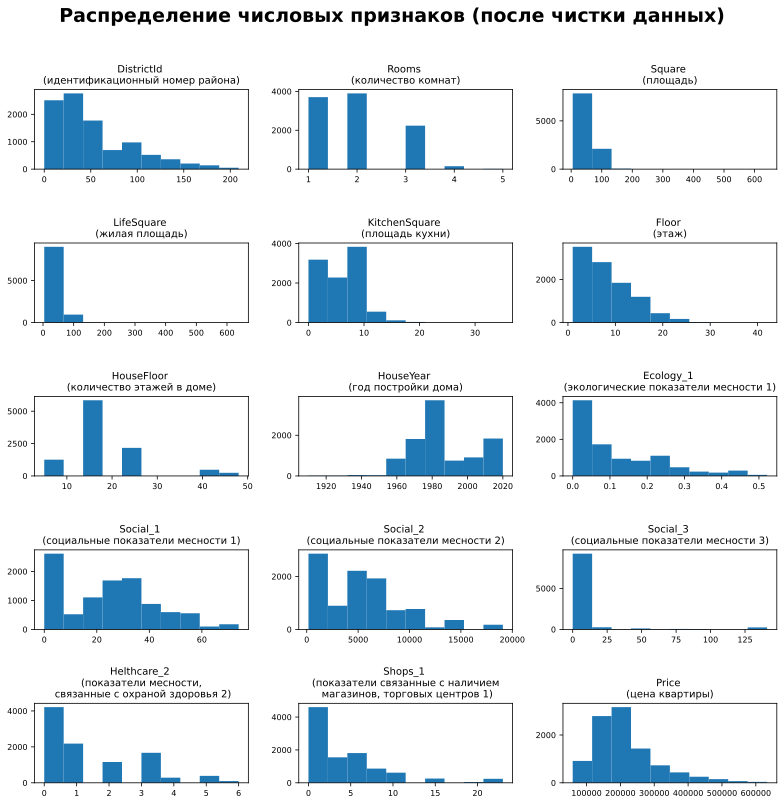

In [190]:
# Разделим числовые и строковые признаки
num_cols, str_cols = numeric_and_string_attributes(train_data)
# Посмотрим визуально на графики числовых переменных
visualization_numerical_characteristics(dop_text='(после чистки данных)')

### Создание класса подготовки данных <a class='anchor' id='create_class'>

In [191]:
class DataPreprocessing():
    '''
    Класс 'Подготовки исходных данных'

     Атрибуты:
    - kitchen_square_median: медиана площади кухни,
    - rooms_median: медиана количества комнат,
    - house_year_mode: мода года постройки дома.

     Методы:
    - random_floor(self, floor) -> int:  выбор случайной этажности дома для определённой квартиры,
    - numeric_and_string_attributes(self, df): разделяет числовые и строковые признаки,
    - fit(self, X): сохраняет медианы и моды, для последующего использования,
    - transform (self, X): чистит наш датафрейм (заполняет пропуски, исправляет неточности).

     Dunder методы:
    - __init__(self): конструктор класса,
    '''

    def __init__(self):
        # Переменные лласса
        self.house_year_mode = None
        self.kitchen_square_median = None
        self.rooms_median = None

    @staticmethod
    def random_floor(self, floor) -> int:
        '''
        Процедура выбора случайной этажности дома для определённой квартиры.
    
        :param floor: этаж на которой расположена квартира,
        :return: случайная этажность дома или -1, если такого этажа не может быть.
        '''
        
        # Список с этажносстью домов
        house_floor_list = [5, 9, 14, 16, 24, 40, 48]
        # Веса выбора этажности (тоесть многоэтажки 40, 48 выпадают реже)
        weights = [5, 10, 20, 20, 10, 2, 1]
        # Скорректированные веса выбора этажности дома в зависимости от этажа текущей квартиры
        weights_corr = [weights[i] if house_floor_list[i] >= floor else 0 for i in range(len(weights))]
     
        if sum(weights_corr):
            house_floor = rnd.choices(house_floor_list, weights=weights_corr, k=1)
            return house_floor[0]
        else:
            return -1

    @staticmethod
    def numeric_and_string_attributes(self, df):
        '''
        Функция разделяет числовые и строковые признаки.
    
        :param df: исследуемый датафрейм,
        :return: num_cols - список числовых признаков, str_cols - список строковых признаков.
        '''
        # Числовые признаки
        num_cols = []
        # Строковые признаки
        str_cols = []
        
        cols_and_type = df.dtypes.to_dict()
        
        for col in cols_and_type:
            if cols_and_type[col] in ('int64', 'float64'):
                num_cols.append(col)
            else: 
                str_cols.append(col)
    
        return num_cols, str_cols
    
    def fit(self, X):
        '''
        Функция сохраняет статистические данные (медиана, мода)

        :param X: исследуемый датафрейм.
        '''
        self.house_year_mode = X['HouseYear'].mode()[0]
        self.kitchen_square_median = X['KitchenSquare'].median()
        self.rooms_median = X['Rooms'].median()
        
    
    def transform (self, X):
        '''
        Функция чистит данные.

        :param X: исследуемый датафрейм,
        :return: возвращает очищенный датафрейм.
        '''
        # Признак 'HouseYear'
        # Заменим все года постройки, которые больше текущего года на моду
        X.loc[X['HouseYear'] > datetime.now().year, ['HouseYear']] = self.house_year_mode

        
        # Признак 'Rooms'
        # Создадим индексы строк в которых 5 и более комнат, а их площадь менее 100 или меньше одной комнаты
        index_edit = X.query('(((Rooms >= 5) & (Square < 100)) | (Rooms < 1))').index
        # Заменим аномальные значения на медиану
        X.loc[index_edit, ['Rooms']] = self.rooms_median

        
        # Признак 'KitchenSquare'
        # Заменим все кухни, которые больше 35 квадратов на медиану
        X.loc[X['KitchenSquare'] > 35, ['KitchenSquare']] = self.kitchen_square_median


        # Признаки 'Square' и 'LifeSquare'
        # Чтобы метраж у каждой квартиры, был уникальным - маловероятно. Округлим метраж до целых чисел
        X['Square'] = X['Square'].apply(lambda x: round(x, 0))
        X['LifeSquare'] = X['LifeSquare'].apply(lambda x: round(x, 0))
        # 
        # Заменим экстримальные значения LifeSquare
        X.loc[(X['LifeSquare'] > X['Square'].max()), ['LifeSquare']] = X['Square']
        # 
        # Заменим совсем уж маленькую площадь
        X.loc[(X['Square'] < 5), ['Square']] = 5
        # 
        # Заменим не корректные значения Square на LifeSquare + KitchenSquare
        X.loc[(X['Square'] < X['LifeSquare']), ['Square']] = X['LifeSquare'] + X['KitchenSquare']
        # 
        # Заменим не корректные значения LifeSquare на Square - KitchenSquare
        X.loc[(X['Square'] == X['LifeSquare']), ['LifeSquare']] = X['Square'] - X['KitchenSquare']
        # 
        # Заменим недостающие значения LifeSquare или значения < 20.   LifeSquare = Square - KitchenSquare
        X.loc[((X['LifeSquare'].isna()) | (X['LifeSquare'] < 20)), ['LifeSquare']] = X['Square'] - X['KitchenSquare']


        # Признаки 'HouseFloor' и 'Floor'
        # Зададим начальное значение модуля rnd
        rnd.seed(42)
        # Заменим ошибочную этажность дома на релевантную 
        X['HouseFloor'] = X['Floor'].apply(lambda x: self.random_floor(self, x))


        # Признак 'Healthcare_1'
        # В фиче 'Healthcare_1' пропущено 50% записей - этот признак не информативен, удалим его
        X.drop('Healthcare_1', axis=1, inplace=True)

        # Разделим числовые и строковые признаки
        num_cols, str_cols = self.numeric_and_string_attributes(self, X)

        # Изменим тип признаков
        le = LabelEncoder()
        # Пробежимся по строковым столбцам датафрейма и преобразуем буквеное обозначение в цифровое
        for col in  str_cols:
            X[col] = le.fit_transform(X[col].astype(str))
        # 
        # Переведём Id квартиры в строковый формат
        X['Id'] = X['Id'].astype(str)

        return X

In [192]:
# Проверим как работает
# Читаем csv файл тренировочных данных
train_data_new = pd.read_csv(TRAIN_DATA, engine='python', on_bad_lines='skip')
train_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.00,48.00,29.00,6.00,7,16,1969,0.09,1,1,33,7976,5,0,11,1,184966.93
1,15053,41,3.00,66.00,40.00,8.00,7,9,1978,0.00,1,1,46,10309,1,1,16,1,300009.45
2,4765,53,2.00,45.00,29.00,0.00,8,14,1968,0.05,1,1,34,7759,0,1,3,1,220925.91
3,5809,58,2.00,53.00,44.00,9.00,8,14,1977,0.44,1,1,23,5735,3,0,5,1,175616.23
4,10783,99,1.00,40.00,24.00,7.00,11,16,1976,0.01,1,1,35,5776,1,2,4,1,150226.53


In [193]:
# Создадим объект класса
dp = DataPreprocessing()
# Сохраним стат. данные 
dp.fit(train_data_new)
# Сохраним очищенный датасет
proverka = dp.transform(train_data_new)
# Сравним два датафрейма (который изменили ранее и изменённый с помощью объекта класса)
proverka.equals(train_data)

True

**Ура!!!** Значит я ничего не упустил в классе. Датафрйм изменённый ранее и датафрейм изменённый с помощью объекта класса, совпадают.

### Построение новых признаков <a class='anchor' id='new_feature'>

#### DistrictSize, IsDistrictLarge (размеры районов) <a class='anchor' id='district_size'>

In [194]:
# Посмотрим как распределены номера районов
district_size = train_data['DistrictId'].value_counts().reset_index().rename(columns={'index': 'DistrictId', 'DistrictId': 'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [195]:
# Добавим 'DistrictSize' к нашему датафрейму
train_data = train_data.merge(district_size, on='DistrictId', how='left')
train_data.head(20)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize
0,14038,35,2.00,48.00,29.00,6.00,7,16,1969,0.09,1,1,33,7976,5,0,11,1,184966.93,22
1,15053,41,3.00,66.00,40.00,8.00,7,9,1978,0.00,1,1,46,10309,1,1,16,1,300009.45,87
2,4765,53,2.00,45.00,29.00,0.00,8,14,1968,0.05,1,1,34,7759,0,1,3,1,220925.91,174
3,5809,58,2.00,53.00,44.00,9.00,8,14,1977,0.44,1,1,23,5735,3,0,5,1,175616.23,179
4,10783,99,1.00,40.00,24.00,7.00,11,16,1976,0.01,1,1,35,5776,1,2,4,1,150226.53,97
5,12915,59,3.00,80.00,47.00,12.00,5,16,2011,0.31,1,1,35,7715,4,0,6,1,215898.45,67
6,14549,154,2.00,62.00,37.00,7.00,3,24,1960,0.46,1,1,20,4386,14,1,5,1,296021.20,10
7,11993,74,2.00,80.00,80.00,0.00,14,14,1977,0.08,1,1,6,1437,3,0,2,1,221244.16,114
8,5172,1,2.00,65.00,64.00,1.00,9,14,1977,0.01,1,1,1,264,0,0,1,1,229102.80,652
9,8649,23,1.00,46.00,38.00,8.00,13,14,2014,0.08,1,1,6,1437,3,0,2,1,95380.22,565


In [196]:
# Посмотрим как распределяется 'DistrictSize'
(train_data['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [197]:
# Добавим новый признак 'IsDistrictLarge'
train_data['IsDistrictLarge'] = (train_data['DistrictSize'] > 100).astype(int)
train_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge
0,14038,35,2.00,48.00,29.00,6.00,7,16,1969,0.09,...,1,33,7976,5,0,11,1,184966.93,22,0
1,15053,41,3.00,66.00,40.00,8.00,7,9,1978,0.00,...,1,46,10309,1,1,16,1,300009.45,87,0
2,4765,53,2.00,45.00,29.00,0.00,8,14,1968,0.05,...,1,34,7759,0,1,3,1,220925.91,174,1
3,5809,58,2.00,53.00,44.00,9.00,8,14,1977,0.44,...,1,23,5735,3,0,5,1,175616.23,179,1
4,10783,99,1.00,40.00,24.00,7.00,11,16,1976,0.01,...,1,35,5776,1,2,4,1,150226.53,97,0


#### MedPriceDistrict (медиана цены квартиры в зависимости от района и количества комнат) <a class='anchor' id='med_price_district'>

In [198]:
# Средняя цена квартиры в зависимости от района и количества комнат
med_price_by_district = train_data.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByDistrict'})  
med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.00,142799.43
1,0,2.00,176210.81
2,0,3.00,300610.36
3,1,1.00,146735.67
4,1,2.00,202666.31


In [199]:
# Добавляем этот признак в датафрейм
train_data = train_data.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,14038,35,2.00,48.00,29.00,6.00,7,16,1969,0.09,...,33,7976,5,0,11,1,184966.93,22,0,207786.14
1,15053,41,3.00,66.00,40.00,8.00,7,9,1978,0.00,...,46,10309,1,1,16,1,300009.45,87,0,300009.45
2,4765,53,2.00,45.00,29.00,0.00,8,14,1968,0.05,...,34,7759,0,1,3,1,220925.91,174,1,262760.66
3,5809,58,2.00,53.00,44.00,9.00,8,14,1977,0.44,...,23,5735,3,0,5,1,175616.23,179,1,166809.67
4,10783,99,1.00,40.00,24.00,7.00,11,16,1976,0.01,...,35,5776,1,2,4,1,150226.53,97,0,158539.05


#### MedPriceByFloorYear (средняя цена квартиры в зависимости от этажа и года постройки дома) <a class='anchor' id='med_price_by_floor_year'>

In [200]:
def floor_to_cat(X):
    '''
    Функция разбивает квартиры на категории в зависимости от этажа.

    :param X: исследуемый датафрейм,
    :return: датафрейм с признаком категории этажности.
    '''
    # Этот код анологичен встроенной функии Pandas pd.cut
    # X['floor_cat'] = 0

    # X.loc[X['Floor'] <= 3, 'floor_cat'] = 1
    # X.loc[X['Floor'] > 3, 'floor_cat'] = 2
    # X.loc[X['Floor'] > 5, 'floor_cat'] = 3
    # X.loc[X['Floor'] > 9, 'floor_cat'] = 4
    # X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    # На сколько категорий будем делить: 0-3, 3-5, 5-9, 15-max
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    X['floor_cat'].fillna(-1, inplace=True)
    
    return X

In [201]:
def year_to_cat(X):
    '''
    Функция разбивает квартиры на категории в зависимости от года постройки дома.

    :param X: исследуемый датафрейм,
    :return: датафрейм с признаком категории постройки дома.
    '''

    # Этот код анологичен встроенной функии Pandas pd.cut
    # X['year_cat'] = 0

    # X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    # X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    # X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    # X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    # X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    # X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    X['year_cat'].fillna(-1, inplace=True)

    return X

In [202]:
# Создадим дополнительные признаки
train_data = year_to_cat(train_data)
train_data = floor_to_cat(train_data)
train_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,14038,35,2.00,48.00,29.00,6.00,7,16,1969,0.09,...,5,0,11,1,184966.93,22,0,207786.14,2,2
1,15053,41,3.00,66.00,40.00,8.00,7,9,1978,0.00,...,1,1,16,1,300009.45,87,0,300009.45,2,2
2,4765,53,2.00,45.00,29.00,0.00,8,14,1968,0.05,...,0,1,3,1,220925.91,174,1,262760.66,2,2
3,5809,58,2.00,53.00,44.00,9.00,8,14,1977,0.44,...,3,0,5,1,175616.23,179,1,166809.67,2,2
4,10783,99,1.00,40.00,24.00,7.00,11,16,1976,0.01,...,1,2,4,1,150226.53,97,0,158539.05,2,3


In [203]:
# Рассчитаем среднею стоимость по этажам и по году
med_price_by_floor_year = train_data.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'mean'}).rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,0,0,349047.61
1,0,1,324513.59
2,0,2,356523.90
3,0,3,400715.47
4,1,0,467230.54


In [204]:
# Добавим новый признак в датафрейм
train_data = train_data.merge(med_price_by_floor_year, on=['year_cat','floor_cat'], how='left')
train_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,14038,35,2.00,48.00,29.00,6.00,7,16,1969,0.09,...,0,11,1,184966.93,22,0,207786.14,2,2,205008.34
1,15053,41,3.00,66.00,40.00,8.00,7,9,1978,0.00,...,1,16,1,300009.45,87,0,300009.45,2,2,205008.34
2,4765,53,2.00,45.00,29.00,0.00,8,14,1968,0.05,...,1,3,1,220925.91,174,1,262760.66,2,2,205008.34
3,5809,58,2.00,53.00,44.00,9.00,8,14,1977,0.44,...,0,5,1,175616.23,179,1,166809.67,2,2,205008.34
4,10783,99,1.00,40.00,24.00,7.00,11,16,1976,0.01,...,2,4,1,150226.53,97,0,158539.05,2,3,197437.43


### Создание класса новых признаков <a class='anchor' id='create_class_2'>

In [205]:
class FeatureGenerator():
    '''
    Класс 'Генерации новых фич'

     Атрибуты:
    - house_year_max: максимальный год постройки дома,
    - floor_max: максимальное число комнат,
    - med_price_by_district: средняя цена квартиры в зависимости от района и количества комнат,
    - med_price_by_floor_year: средняя стоимость по этажам и по году постройки дома.

     Методы:
    - fit(self, X): сохраняет макс. значения и другие параметры, для последующего использования,
    - transform (self, X): добавляет новые фичи в датафрейм.

     Dunder методы:
    - __init__(self): конструктор класса,
    '''

    def __init__(self):
        # Переменные лласса
        self.house_year_max = None
        self.floor_max = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        
    
    def fit(self, X):
        '''
        Функция сохраняет необходимые данные.

        :param X: исследуемый датафрейм.
        '''
        self.house_year_max = X['HouseYear'].max()
        self.floor_max = X['Floor'].max()
        
    
    def transform (self, X):
        '''
        Функция добавляет новые фичи.

        :param X: исследуемый датафрейм,
        :return: возвращает датафрейм с новыми фичами.
        '''
        x = X.copy()

        # Посмотрим как распределены номера районов
        district_size = x['DistrictId'].value_counts().reset_index().rename(columns={'index': 'DistrictId', 'DistrictId': 'DistrictSize'})
        # Добавим 'DistrictSize' к нашему датафрейму
        x = x.merge(district_size, on='DistrictId', how='left')
        
        # Добавим новый признак 'IsDistrictLarge'
        x['IsDistrictLarge'] = (x['DistrictSize'] > 100).astype(int)

        if self.med_price_by_district is None:
            # Средняя цена квартиры в зависимости от района и количества комнат
            self.med_price_by_district = x.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'}).rename(columns={'Price':'MedPriceByDistrict'})  
        # Добавляем этот признак в датафрейм
        x = x.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

        # Категории постройки дома (год)
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        x['year_cat'] = pd.cut(x['HouseYear'], bins=bins, labels=False)
        x['year_cat'].fillna(-1, inplace=True)

        # На сколько категорий будем делить этажность дома: 0-3, 3-5, 5-9, 15-max
        bins = [0, 3, 5, 9, 15, self.floor_max]
        x['floor_cat'] = pd.cut(x['Floor'], bins=bins, labels=False)
        x['floor_cat'].fillna(-1, inplace=True)

        if self.med_price_by_floor_year is None:
            # Рассчитаем среднею стоимость по этажам и по году
            self.med_price_by_floor_year = x.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'mean'}).rename(columns={'Price':'MedPriceByFloorYear'})
        # Добавим новый признак в датафрейм
        x = x.merge(self.med_price_by_floor_year, on=['year_cat','floor_cat'], how='left')
        
        return x

In [206]:
# Проверим как работает
# Читаем csv файл тренировочных данных
train_data_new = pd.read_csv(TRAIN_DATA, engine='python', on_bad_lines='skip')
train_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,14038,35,2.00,48.00,29.00,6.00,7,16,1969,0.09,...,0,11,1,184966.93,22,0,207786.14,2,2,205008.34
1,15053,41,3.00,66.00,40.00,8.00,7,9,1978,0.00,...,1,16,1,300009.45,87,0,300009.45,2,2,205008.34
2,4765,53,2.00,45.00,29.00,0.00,8,14,1968,0.05,...,1,3,1,220925.91,174,1,262760.66,2,2,205008.34
3,5809,58,2.00,53.00,44.00,9.00,8,14,1977,0.44,...,0,5,1,175616.23,179,1,166809.67,2,2,205008.34
4,10783,99,1.00,40.00,24.00,7.00,11,16,1976,0.01,...,2,4,1,150226.53,97,0,158539.05,2,3,197437.43


In [207]:
# Создадим объект класса
dp = DataPreprocessing()
# Сохраним стат. данные 
dp.fit(train_data_new)
# Сохраним очищенный датасет
proverka = dp.transform(train_data_new)

# Создадим объект класса
fg = FeatureGenerator()
# Сохраним стат. данные 
fg.fit(proverka)
# Сгенерим дополнительные фичи
proverka = fg.transform(proverka)
# Сравним два датафрейма (который изменили ранее и изменённый с помощью объекта класса)
proverka.equals(train_data)

True

**Ура!!!** Значит я ничего не упустил в классе. Датафрйм изменённый ранее и датафрейм с новыми фичами, изменённый с помощью объекта класса, совпадают.

### Создание модели <a class='anchor' id='create_model'>

#### Проверим модель без генерации новых фич <a class='anchor' id='model_1'>

In [208]:
# Читаем csv файл тренировочных данных
train_data = pd.read_csv(TRAIN_DATA, engine='python', on_bad_lines='skip')
# Читаем csv файл тестовых данных
test_data = pd.read_csv(TEST_DATA, engine='python', on_bad_lines='skip')

# Создадим объект класса
dp = DataPreprocessing()
# Сохраним стат. данные 
dp.fit(train_data)
# Сохраним очищенный датасет (train)
X = dp.transform(train_data)
# Сохраним очищенный датасет (test)
test_data = dp.transform(test_data)

# Создадим целевую переменную (таргет)
y = X['Price']
# Удалим таргет из тренировочных данных
X_not_price = X.drop('Price', axis=1)

In [209]:
# Разобьём выборку на тренировочную (70%) и валидную (30%)
X_train, X_valid, y_train, y_valid = train_test_split(X_not_price, y, test_size=0.3, random_state=42)

In [210]:
# Посмотрим размерность датафремов
(X_train.shape, X_valid.shape, test_data.shape)

((7000, 18), (3000, 18), (5000, 18))

In [211]:
# Создадим модель с количеством деревьев в лесу 2000, с максимальной глубиной залегания дерева 21 (эти параметры подобрал с помощью GridSearchCV)
rf_model = RandomForestRegressor(n_estimators=2000, max_depth=21, random_state=42, criterion='squared_error')

In [212]:
%%time
# Обучим модель
rf_model.fit(X_train, y_train) 

CPU times: total: 1min 31s
Wall time: 1min 31s


RandomForestRegressor(max_depth=21, n_estimators=2000, random_state=42)

In [213]:
%%time
# Выполним обучение модели с кросс-валидацией
cv = cross_validate(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True))

CPU times: total: 3min 25s
Wall time: 3min 25s


In [214]:
# Средняя эффективность по метрике r2
print(f'Средняя эффективность по метрике r2: {cv["test_score"].mean()}')

Средняя эффективность по метрике r2: 0.7236883284569631


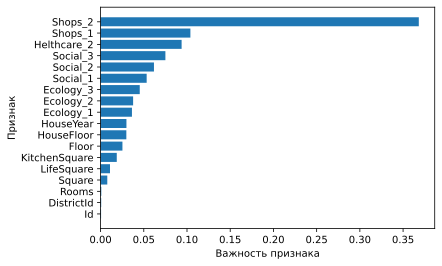

In [215]:
# Задаем размер фигуры
plt.rcParams['figure.figsize'] = 6, 4
# Задаём данные для отрисовки
plt.barh(X_train.keys().tolist(), np.sort(rf_model.feature_importances_))
# Подписываем оси
plt.xlabel("Важность признака")
plt.ylabel("Признак")

plt.show()

Оценим точность модели на данных, которые она не видела (X_valid, y_valid)

In [216]:
# Выполним предикт
y_pred = rf_model.predict(X_valid)
# Посмотрим эффективность модели по метрике r2
print(f'Эффективность модели по метрике r2: {r2_score(y_valid, y_pred)}')

Эффективность модели по метрике r2: 0.7130455368806853


#### Проверим модель с генерацией новых фич <a class='anchor' id='model_2'>

In [217]:
# Создадим объект класса
fg = FeatureGenerator()
# Сохраним стат. данные 
fg.fit(X)
# Сгенерим дополнительные фичи (train)
X_new_features = fg.transform(X)
# Удалим таргет из тренировочных данных
X_new_features = X_new_features.drop('Price', axis=1)
# Сгенерим дополнительные фичи (test)
test_data = fg.transform(test_data)

# Посмотрим, что получилось 
X_new_features.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,14038,35,2.00,48.00,29.00,6.00,7,16,1969,0.09,...,5,0,11,1,22,0,207786.14,2,2,205008.34
1,15053,41,3.00,66.00,40.00,8.00,7,9,1978,0.00,...,1,1,16,1,87,0,300009.45,2,2,205008.34
2,4765,53,2.00,45.00,29.00,0.00,8,14,1968,0.05,...,0,1,3,1,174,1,262760.66,2,2,205008.34
3,5809,58,2.00,53.00,44.00,9.00,8,14,1977,0.44,...,3,0,5,1,179,1,166809.67,2,2,205008.34
4,10783,99,1.00,40.00,24.00,7.00,11,16,1976,0.01,...,1,2,4,1,97,0,158539.05,2,3,197437.43


In [218]:
# Разобьём выборку на тренировочную (70%) и валидную (30%)
X_train, X_valid, y_train, y_valid = train_test_split(X_new_features, y, test_size=0.3, random_state=42)

In [219]:
# Посмотрим размерность датафремов
(X_train.shape, X_valid.shape, test_data.shape)

((7000, 24), (3000, 24), (5000, 24))

In [220]:
# Создадим модель с количеством деревьев в лесу 2000, с максимальной глубиной залегания дерева 21 (эти параметры подобрал с помощью GridSearchCV)
rf_model_new_features = RandomForestRegressor(n_estimators=2000, max_depth=21, random_state=42, criterion='squared_error')

In [221]:
%%time
# Обучим модель
rf_model_new_features.fit(X_train, y_train)

CPU times: total: 1min 59s
Wall time: 1min 59s


RandomForestRegressor(max_depth=21, n_estimators=2000, random_state=42)

In [222]:
%%time
# Выполним обучение модели с кросс-валидацией
cv = cross_validate(rf_model_new_features, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True))

CPU times: total: 4min 26s
Wall time: 4min 26s


In [223]:
# Средняя эффективность по метрике r2
print(f'Средняя эффективность по метрике r2: {cv["test_score"].mean()}')

Средняя эффективность по метрике r2: 0.7464895490783494


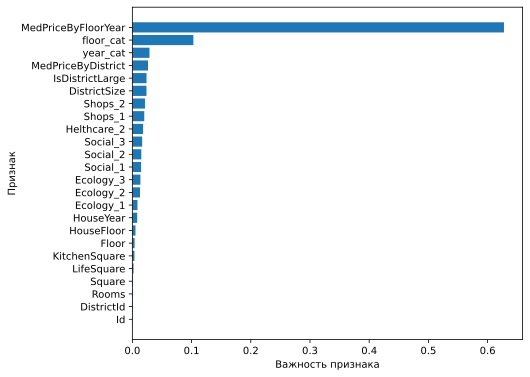

In [224]:
# Задаем размер фигуры
plt.rcParams['figure.figsize'] = 7, 6
# Задаём данные для отрисовки
plt.barh(X_train.keys().tolist(), np.sort(rf_model_new_features.feature_importances_))
# Подписываем оси
plt.xlabel("Важность признака")
plt.ylabel("Признак")

plt.show()

Оценим точность модели на данных, которые она не видела (X_valid, y_valid)

In [225]:
# Выполним предикт
y_pred = rf_model_new_features.predict(X_valid)
# Посмотрим эффективность модели по метрике r2
print(f'Эффективность модели по метрике r2: {r2_score(y_valid, y_pred)}')

Эффективность модели по метрике r2: 0.7372916129260703


### Прогнозирование на тестовом датасете <a class='anchor' id='prognoz'>

In [226]:
# Посмотрим размерность датасета
test_data.shape

(5000, 24)

In [227]:
# Выполняем предикт
predictions = rf_model_new_features.predict(test_data)
predictions

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
# Запишем в датасет Id и Price
df_predict = pd.DataFrame()
df_predict['Id'] = test_data['Id']
df_predict['Price'] = predictions

# Посмотрим, что получилось
df_predict.head()

In [ ]:
# Запишем в CSV файл
df_predict.to_csv('./predict.csv', encoding='utf-8')

### Вывод: <a class='anchor' id='vivod'>
Точность модели по метрике `r2`, на датасете без генерации дополнительных фич составила `71%`, на датасете с генерацией дополнительных фич составила `74%`. Общее время выполнения всего ноутбука составило `8,5` минут, по сколько я обучал две модели (с дополнительными фичами и без них), плюс еще кросс-валидация на этих моделях, чтобы посмотреть их реальную эффективность. 

От себя замечу, что конечно нужны консультации с риэлтором, который знает все тонкости о квартирах. Возможно есть выбросы, которые я не посчитал выбросами.
